In [1]:
#%load_ext snakeviz
%matplotlib inline

In [2]:
#librerias utilitarias
from random import randint
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [4]:
from utils.multi_gpu import make_parallel

In [21]:
import pandas as pd

In [5]:
from utils.plot import plot_image

In [5]:
!nvidia-smi

Fri Jun 16 01:56:50 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:17.0     Off |                    0 |
| N/A   62C    P0    62W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 0000:00:18.0     Off |                    0 |
| N/A   50C    P0    74W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Cargar Datos
___

In [4]:
train_data = sio.loadmat('data/train_32x32.mat')
test_data = sio.loadmat('data/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
#print (np.unique(y_train))
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(73257, 3, 32, 32)
(26032, 3, 32, 32)
(73257, 10)
(26032, 10)


In [5]:
Y_test_parallel =np.delete(Y_test, 1, 0)
X_test_parallel =np.delete(X_test, 1, 0)
Y_train_parallel =np.delete(Y_train, 1, 0)
X_train_parallel =np.delete(X_train, 1, 0)
print (X_train_parallel.shape)
print (X_test_parallel.shape)
print (Y_train_parallel.shape)
print (Y_test_parallel.shape)

(73256, 3, 32, 32)
(26031, 3, 32, 32)
(73256, 10)
(26031, 10)


Objetivo
-----

**(i)**(Opcional, Bonus +10 en certamen) Evalu ́e la conveniencia de utilizar todo el dataset (“extra 32x32.mat”) en el entrenamiento de la red.

Para el trabajo con el dataset completo se trabajo en formato de script, se genero el modelo y compilo y guardo el modelo, se realizará una comparación en tres dimensiones:

-	Acurracy un modelo con el dataset completo versus el base.
-	Visualizar el efecto de los feature maps sobre un input especifico.
-	Determine los pares de dígitos que ambo modelos tienden a confundir.

**Nota:**Para el modelo entrenado con dataset test_32x32.mat nos referiremos como **modelo_base** y para el modelo entrenado con extra_32x32.mat no referiremos como **modelo_completo**. 

**Es importante destacar que ambos modelos comparte la arquitectura, que es la que fue usada en la actividad (b).**

1 .- Acurracy
-----


In [15]:
from keras.models import load_model
model_completo = load_model('modeloCompleto.h5')

In [16]:
from keras.models import load_model
model_base = load_model('modeloBase.h5')

El modelo_completo es claramente superior en acurracy, solo al este modelo seleccionado para el modelo_base si no que también es el que presenta los mejores resultados de todas las experiencias realizadas, con un **accuracy del 98.02%**

In [38]:
scores_1 = model_base.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo BASE: %.2f%%" % (scores_1[1]*100))
print("Loss del modelo BASE: %.2f%%" % (scores_1[0]*100))
scores_2 = model_completo.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo COMPLETO: %.2f%%" % (scores_2[1]*100))
print("Loss del modelo COMPLETO: %.2f%%" % (scores_2[0]*100))

25920/26032 [============================>.] - ETA: 0s 

2 .- Visualice los pesos correspondientes a los filtros de la primera capa convolucional
-----


In [36]:
imag = random.choice(X_test)
imagen = np.ascontiguousarray(imag.transpose(2,1,0))
imagen.shape

(32, 32, 3)

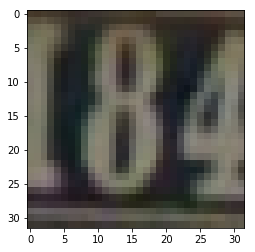

In [37]:
plt.figure()
plt.imshow(imagen)
plt.show()
plt.close()

In [38]:
get_1rd_layer_output_base = K.function([model_base.layers[0].input],
                                  [model_base.layers[0].output])
layer_output_base = get_1rd_layer_output_base([np.array([imag])])[0]

In [39]:
get_1rd_layer_output_completo = K.function([model_completo.layers[0].input],
                                  [model_completo.layers[0].output])
layer_output_completo = get_1rd_layer_output_completo([np.array([imag])])[0]

### Modelo base
---

Como se indico enla actividad (h), el poder ver en accion la accion de una capa convolucional es a mi opinión, la mas llamativa porque permite ver los feature maps y como cada uno se va especializando en determinas características por ejemplo bordes, texturas, formas, etc… del input. Por ejemplo en el modelo con el dataset de entrenamiento normal train_32x32 (no completo) podemos ver que los filtros 2 y 6 no detectan nada en este input, por otro lado los feature maps	 8,10 y 16 parecen estar especializados en reconocer características que el digito 8 tiene. 

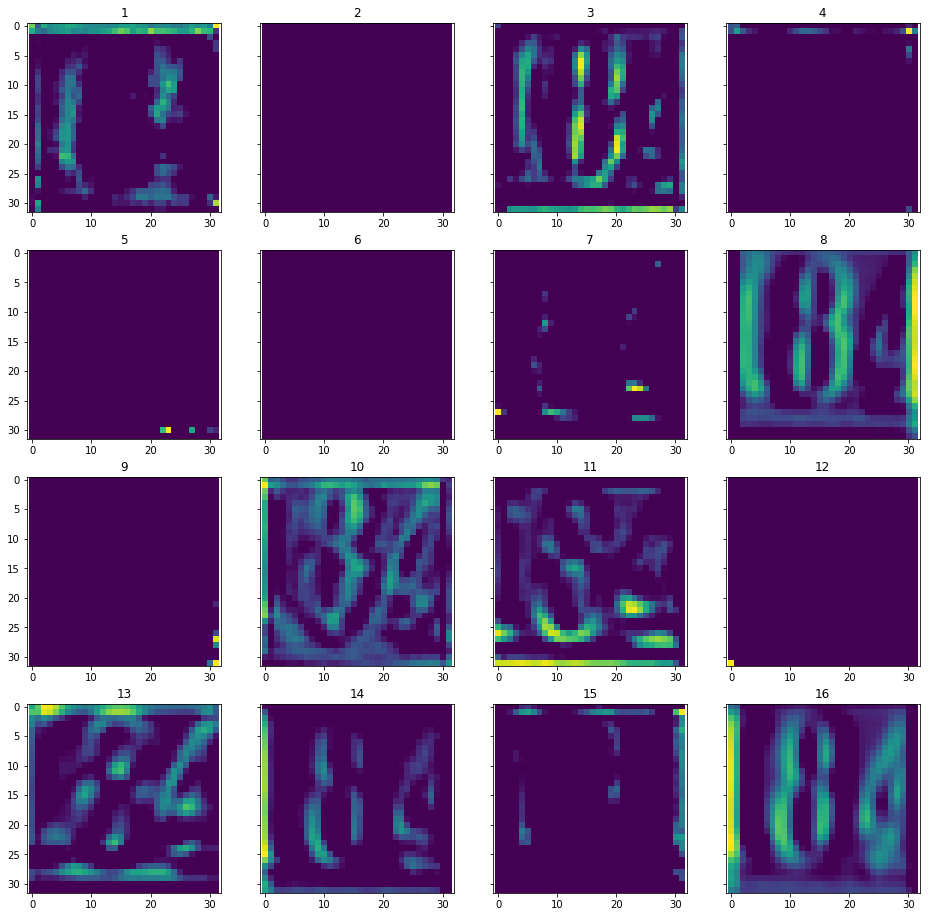

In [40]:
plot_image(layer_output_base)

### Modelo Completo
---

Con el dataset completo los feature maps tiene un entrenamiento mucho mas acabado, como podemos ver los feature maps 5-6-7-9-11 estan preparados para detectar características presentes en el input. Pero la diferencia entre el 6 y 7 es clave para entender el funcionamiento de las redes convolucionales, pues como vemos el 6 esta especializado en detectar la formar o el contenido que esta dentro de los bordes del numero 8, pero el feature maps 7 esta calibrado para detectar o reconocer lo contrario, es decir las formas que están fuera del numero 8.

Con lo ultimo podemos ver en acción, la potencia y especialización lograda primero con el una arquitectura convolucional, y también como el tamaño del dataset influye en la especialización de los feature maps. 

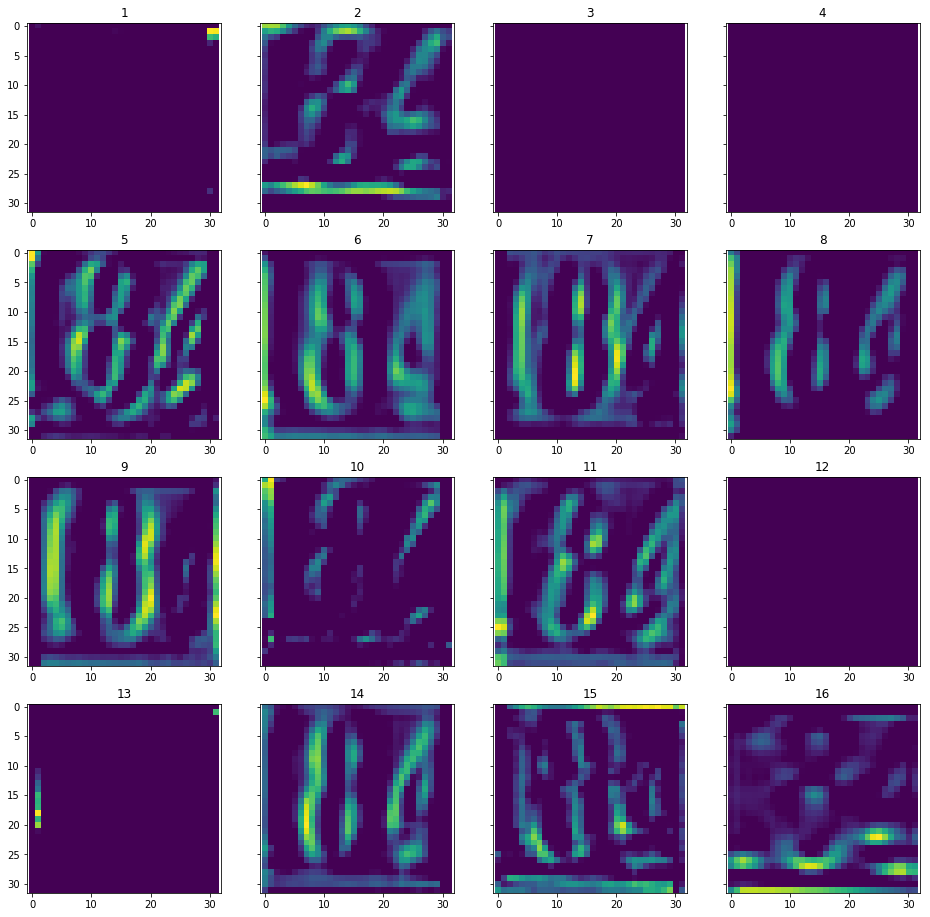

In [41]:
plot_image(layer_output_completo)

3 .- Elija una de las redes entrenadas en esta seccion y determine los pares de dıgitos (por ejemplo “1” con “7”) que la red tiende a confundir.
-----


In [8]:
clases=['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']

**Paso 1**: consiste en encontrar los índices donde están los ejemplos de cada categoría, para se implemento la función:

In [10]:
def buscarLabelCategoria_(clase,Yt_):
    indices=[]
    for i in range(len(Yt_)):
        if Yt_[i] == clase:
            indices.append(i)
    return np.array(indices)

In [11]:
indices_cero = buscarLabelCategoria_(0, y_test)
indices_uno = buscarLabelCategoria_(1, y_test)
indices_dos = buscarLabelCategoria_(2, y_test)
indices_tres = buscarLabelCategoria_(3, y_test)
indices_cuatro = buscarLabelCategoria_(4, y_test)
indices_cinco = buscarLabelCategoria_(5, y_test)
indices_seis = buscarLabelCategoria_(6, y_test)
indices_siete = buscarLabelCategoria_(7, y_test)
indices_ocho = buscarLabelCategoria_(8, y_test)
indices_nueve = buscarLabelCategoria_(9, y_test)

**Paso 2**: Ya con el listado de índices de cada categoría, se selecciona un subset de datos para cada categoría, para esto se implemento la función:

In [12]:
def seleccionarSubconjuntoClase_(listaIndices_,X_test_):
    dataSetClase=[]
    for i in listaIndices_:
        dataSetClase.append(X_test_[i])
    return np.array(dataSetClase)

In [13]:
dataset_cero = seleccionarSubconjuntoClase_(indices_cero,X_test)
dataset_uno = seleccionarSubconjuntoClase_(indices_uno,X_test)
dataset_dos = seleccionarSubconjuntoClase_(indices_dos,X_test)
dataset_tres = seleccionarSubconjuntoClase_(indices_tres,X_test)
dataset_cuatro = seleccionarSubconjuntoClase_(indices_cuatro,X_test)
dataset_cinco = seleccionarSubconjuntoClase_(indices_cinco,X_test)
dataset_seis = seleccionarSubconjuntoClase_(indices_seis,X_test)
dataset_siete = seleccionarSubconjuntoClase_(indices_siete,X_test)
dataset_ocho = seleccionarSubconjuntoClase_(indices_ocho,X_test)
dataset_nueve = seleccionarSubconjuntoClase_(indices_nueve,X_test)

**Paso 3**: Ahora leemos el modelo guardo, el que mostro el mejor acurracy, y aplicado el predicción a cada dataset de cada catagoria:

**Con el modelo usando :**

In [19]:
%%time
prediccion_cero_completo= model_completo.predict(dataset_cero, verbose=1)
prediccion_uno_completo= model_completo.predict(dataset_uno, verbose=0)
prediccion_dos_completo= model_completo.predict(dataset_dos, verbose=0)
prediccion_tres_completo= model_completo.predict(dataset_tres, verbose=0)
prediccion_cuatro_completo= model_completo.predict(dataset_cuatro, verbose=0)
prediccion_cinco_completo= model_completo.predict(dataset_cinco, verbose=0)
prediccion_seis_completo= model_completo.predict(dataset_seis, verbose=0)
prediccion_siete_completo= model_completo.predict(dataset_siete, verbose=0)
prediccion_ocho_completo= model_completo.predict(dataset_ocho, verbose=0)
prediccion_nueve_completo= model_completo.predict(dataset_nueve, verbose=1)

1632/1744 [===========================>..] - ETA: 0s

In [18]:
%%time
prediccion_cero_base= model_base.predict(dataset_cero, verbose=1)
prediccion_uno_base= model_base.predict(dataset_uno, verbose=0)
prediccion_dos_base= model_base.predict(dataset_dos, verbose=0)
prediccion_tres_base= model_base.predict(dataset_tres, verbose=0)
prediccion_cuatro_base= model_base.predict(dataset_cuatro, verbose=0)
prediccion_cinco_base= model_base.predict(dataset_cinco, verbose=0)
prediccion_seis_base= model_base.predict(dataset_seis, verbose=0)
prediccion_siete_base= model_base.predict(dataset_siete, verbose=0)
prediccion_ocho_base= model_base.predict(dataset_ocho, verbose=0)
prediccion_nueve_base= model_base.predict(dataset_nueve, verbose=1)

1632/1744 [===========================>..] - ETA: 0s

**Paso 4**: Desde en este paso en adelante, usaremos la API de Python Pandas que nos permitirá ordenar el resultado de obtenido desde la predicción de Keras. Para esto a partir de la salida de Keras(n-array) pasamos a un pandas dataframe. Y en la misma línea calculamos las mayores frecuencias por cada clase:


In [22]:
df_cero_completo = pd.DataFrame(prediccion_cero_completo).max()
df_uno_completo = pd.DataFrame(prediccion_uno_completo).max()
df_dos_completo = pd.DataFrame(prediccion_dos_completo).max()
df_tres_completo = pd.DataFrame(prediccion_tres_completo).max()
df_cuatro_completo = pd.DataFrame(prediccion_cuatro_completo).max()
df_cinco_completo = pd.DataFrame(prediccion_cinco_completo).max()
df_seis_completo = pd.DataFrame(prediccion_seis_completo).max()
df_siete_completo = pd.DataFrame(prediccion_siete_completo).max()
df_ocho_completo = pd.DataFrame(prediccion_ocho_completo).max()
df_nueve_completo = pd.DataFrame(prediccion_nueve_completo).max()

In [28]:
df_cero_base = pd.DataFrame(prediccion_cero_base).max()
df_uno_base = pd.DataFrame(prediccion_uno_base).max()
df_dos_base = pd.DataFrame(prediccion_dos_base).max()
df_tres_base = pd.DataFrame(prediccion_tres_base).max()
df_cuatro_base = pd.DataFrame(prediccion_cuatro_base).max()
df_cinco_base = pd.DataFrame(prediccion_cinco_base).max()
df_seis_base = pd.DataFrame(prediccion_seis_base).max()
df_siete_base = pd.DataFrame(prediccion_siete_base).max()
df_ocho_base = pd.DataFrame(prediccion_ocho_base).max()
df_nueve_base = pd.DataFrame(prediccion_nueve_base).max()

**Paso 5**: Finalmente aplicamos un sort descendente a la serie de pandas que fue la salida del punto anterior, para en el paso siguiente presentar los valores que tienden a confundirse por categoria:

In [23]:
df_cero_completo.sort_values(inplace=True,ascending=False)
df_uno_completo.sort_values(inplace=True,ascending=False)
df_dos_completo.sort_values(inplace=True,ascending=False)
df_tres_completo.sort_values(inplace=True,ascending=False)
df_cuatro_completo.sort_values(inplace=True,ascending=False)
df_cinco_completo.sort_values(inplace=True,ascending=False)
df_seis_completo.sort_values(inplace=True,ascending=False)
df_siete_completo.sort_values(inplace=True,ascending=False)
df_ocho_completo.sort_values(inplace=True,ascending=False)
df_nueve_completo.sort_values(inplace=True,ascending=False)

In [29]:
df_cero_base.sort_values(inplace=True,ascending=False)
df_uno_base.sort_values(inplace=True,ascending=False)
df_dos_base.sort_values(inplace=True,ascending=False)
df_tres_base.sort_values(inplace=True,ascending=False)
df_cuatro_base.sort_values(inplace=True,ascending=False)
df_cinco_base.sort_values(inplace=True,ascending=False)
df_seis_base.sort_values(inplace=True,ascending=False)
df_siete_base.sort_values(inplace=True,ascending=False)
df_ocho_base.sort_values(inplace=True,ascending=False)
df_nueve_base.sort_values(inplace=True,ascending=False)

In [30]:
clases_cero_completo = df_cero_completo.index
clases_uno_completo = df_uno_completo.index
clases_dos_completo = df_dos_completo.index
clases_tres_completo = df_tres_completo.index
clases_cuatro_completo = df_cuatro_completo.index
clases_cinco_completo = df_cinco_completo.index
clases_seis_completo = df_seis_completo.index
clases_siete_completo = df_siete_completo.index
clases_ocho_completo = df_ocho_completo.index
clases_nueve_completo = df_nueve_completo.index

In [31]:
clases_cero_base = df_cero_base.index
clases_uno_base = df_uno_base.index
clases_dos_base = df_dos_base.index
clases_tres_base = df_tres_base.index
clases_cuatro_base = df_cuatro_base.index
clases_cinco_base = df_cinco_base.index
clases_seis_base = df_seis_base.index
clases_siete_base = df_siete_base.index
clases_ocho_base = df_ocho_base.index
clases_nueve_base = df_nueve_base.index

In [36]:
print("MODELO CON EL DATASET COMPLETO")
print("Para Cero")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_cero_completo[0]]," y " ,clases[clases_cero_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_cero_base[0]]," y " ,clases[clases_cero_base[1]])

print("Para Uno")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_uno_completo[0]]," y " ,clases[clases_uno_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_uno_base[0]]," y " ,clases[clases_uno_base[1]])

print("Para Dos")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_dos_completo[0]]," y " ,clases[clases_dos_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_dos_base[0]]," y " ,clases[clases_dos_base[1]])

print("Para Tres")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_tres_completo[0]]," y " ,clases[clases_tres_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_tres_base[0]]," y " ,clases[clases_tres_base[1]])

print("Para Cuatro")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_cuatro_completo[0]]," y " ,clases[clases_cuatro_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_cuatro_base[0]]," y " ,clases[clases_cuatro_base[1]])

print("Para Cinco")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_cinco_completo[0]]," y " ,clases[clases_cinco_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_cinco_base[0]]," y " ,clases[clases_cinco_base[1]])

print("Para Seis")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_seis_completo[0]]," y " ,clases[clases_seis_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_seis_base[0]]," y " ,clases[clases_seis_base[1]])

print("Para Siete")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_siete_completo[0]]," y " ,clases[clases_siete_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_siete_base[0]]," y " ,clases[clases_siete_base[1]])

print("Para Ocho")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_ocho_completo[0]]," y " ,clases[clases_ocho_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_ocho_base[0]]," y " ,clases[clases_ocho_base[1]])

print("Para Nueve")
print("Modelo Completo, la predicciones suele confundir: ",clases[clases_nueve_completo[0]]," y " ,clases[clases_nueve_completo[1]])
print("Modelo Basico, la predicciones suele confundir: ",clases[clases_nueve_base[0]]," y " ,clases[clases_nueve_base[1]])

MODELO CON EL DATASET COMPLETO
Para Cero
Modelo Completo, la predicciones suele confundir:  cero  y  cuatro
Modelo Basico, la predicciones suele confundir:  cero  y  cuatro
Para Uno
Modelo Completo, la predicciones suele confundir:  uno  y  cero
Modelo Basico, la predicciones suele confundir:  uno  y  cero
Para Dos
Modelo Completo, la predicciones suele confundir:  dos  y  nueve
Modelo Basico, la predicciones suele confundir:  dos  y  nueve
Para Tres
Modelo Completo, la predicciones suele confundir:  tres  y  dos
Modelo Basico, la predicciones suele confundir:  tres  y  cero
Para Cuatro
Modelo Completo, la predicciones suele confundir:  cuatro  y  nueve
Modelo Basico, la predicciones suele confundir:  cuatro  y  nueve
Para Cinco
Modelo Completo, la predicciones suele confundir:  cinco  y  cuatro
Modelo Basico, la predicciones suele confundir:  cinco  y  nueve
Para Seis
Modelo Completo, la predicciones suele confundir:  seis  y  cero
Modelo Basico, la predicciones suele confundir:  seis

Finalmente podemos ver en el caso del modelo completo no confunde ningún numero como primera opción en su categoría, y otro efecto interesante es que disminuyen el numero de ceros o unos como el numero con el cual se confunden, que como comentamos se debía a un desbalance en las categorías hacia estas dos clases.

Las confusiones son mucho mas cercanas a las confusiones que tendría un humano.
